In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle, os

2023-11-07 17:23:41.495487: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model_name = 'enformer'
data_dir = '../data/'
test_results = f'../results/distance_test/{model_name}/'

In [3]:
tile_coords = pd.read_csv(f'../results/sufficiency_test/{model_name}/tile_coordinates.csv', index_col='Unnamed: 0').T
tss_tile = tile_coords.loc['tss'].T.values
cre_tile_coords = tile_coords.loc[[t for t in tile_coords.index if 'tss' not in t]]
cre_tiles_starts = cre_tile_coords[0].values
cre_tiles_starts_abs = np.abs(cre_tiles_starts - tss_tile[0]) // 1000

In [16]:
cre_df = pd.read_csv(f'../results/sufficiency_test/{model_name}_selected_cres.csv')


In [17]:
cre_df

,Unnamed: 0,Normalized CRE effect,seq_id,tile_start,tile_end,context,cell_line,tile class
0,18,0.643710,SIGMAR1_chr9_34635317_-,90804,95804,enhancing,PC-3,Enhancer
1,18,0.488182,S100A11_chr1_152032505_-,90804,95804,enhancing,PC-3,Enhancer
2,20,0.393512,ARHGAP11A_chr15_32615503_+,105804,110804,enhancing,PC-3,Enhancer
3,19,0.391855,PSMD1_chr2_231056893_+,100804,105804,enhancing,PC-3,Enhancer
4,19,0.309734,APOBEC3C_chr22_39014256_+,100804,105804,enhancing,PC-3,Enhancer
...,...,...,...,...,...,...,...,...
958,21,-1.153904,ZNF570_chr19_37469355_+,110804,115804,silencing,K562,Silencer
959,22,-0.341064,ZNF570_chr19_37469355_+,115804,120804,silencing,K562,Silencer
960,19,-0.310034,ENSG00000288000_chr20_43458053_+,100804,105804,silencing,K562,Silencer
961,23,-0.861626,ENSG00000267179_chr19_11925110_+,120804,125804,silencing,K562,Silencer


In [18]:
cre_df['tile start relative to tss'] =  np.abs(cre_df['tile_start'] - tss_tile[0]) // 1000


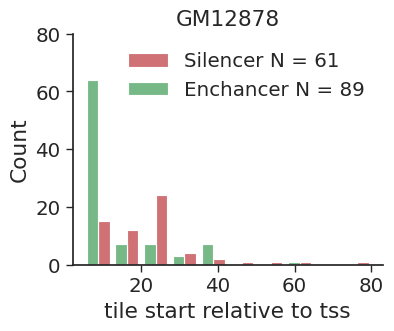

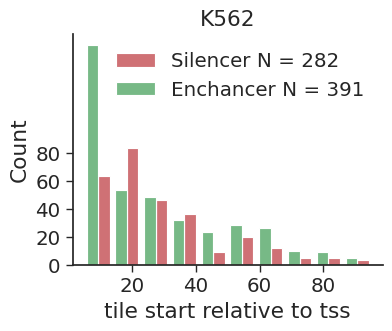

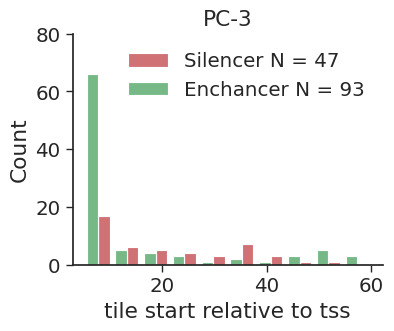

In [19]:

sns.set(font_scale = 1.3)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
color_map = {'Silencer': 'r', 'Enhancer': 'g'}
for cell, df in cre_df.groupby('cell_line'):
    fig, ax = plt.subplots(1, 1, figsize=[4,3])
    N = ({r[0]: r[1] for _,r in df.groupby('tile class').count().iloc[:,1].reset_index().iterrows()})
    sns.histplot(data=df, x='tile start relative to tss', hue='tile class', multiple="dodge", shrink=.8, ax=ax,bins=10, palette=color_map, alpha=0.8)
    ax.set_yticks([0, 20, 40, 60, 80])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend([f'Silencer N = {N["Silencer"]}', f'Enchancer N = {N["Enhancer"]}'], frameon=False)
    plt.title(cell)
    plt.show()

In [8]:
track_index = [4824, 5110, 5111]
target_df = pd.read_csv(f'{data_dir}/{model_name}_targets_human.txt', sep='\t')
cell_lines = [utils.clean_cell_name(target_df.iloc[t]['description']) for t in track_index]
cell_lines

['PC-3', 'GM12878', 'K562']

In [21]:
result_normalized_effects = []
for i, cell_line in enumerate(cell_lines):
    cre_df_cell = cre_df[cre_df['cell_line'] == cell_line]
    cre_df_cell.insert(1, "distance to TSS (Kb)", [np.abs(int(i) - tss_tile[0]) // 1000 for i in cre_df_cell['tile_start'].values ])

    enh_distance_effect = []
    sil_distance_effect = []

    for j, (_, row) in tqdm(enumerate(cre_df_cell.iterrows())):
        tile_start, tile_end = [row['tile_start'], row['tile_end']]
        result_path = f'{test_results}/{row["seq_id"]}_{tile_start}_{tile_end}.pickle'
        res = utils.read_pickle(result_path)
        control = res['mean_control'][447:449,i].mean()
        test = res['mean_mut'][:, 447:449, i].mean(axis=-1)
        norm_effects = test / control
        
        df = pd.DataFrame([norm_effects, cre_tiles_starts_abs]).T
        df.columns = ['Fold change over control', 'Binned distance (Kb)']
        df['Normalized CRE effect (control)'] = row['Normalized CRE effect']
        df['cell line'] = cell_line
        df['context'] = row['context']
        df['tile class'] = row['tile class']
        result_normalized_effects.append(df)
result_normalized_effects = pd.concat(result_normalized_effects)

140it [00:00, 819.59it/s]
150it [00:00, 815.45it/s]
673it [00:01, 650.26it/s]


In [22]:
result_normalized_effects.head(2)


,Fold change over control,Binned distance (Kb),Normalized CRE effect (control),cell line,context,tile class
0,0.011089,95.0,0.64371,PC-3,enhancing,Enhancer
1,0.009526,90.0,0.64371,PC-3,enhancing,Enhancer


In [62]:
my_palette

{'Enhancer N=3382': 'g', 'Silencer N=2318': 'r'}

In [65]:
my_palette = {}
tile_labels = {}
for i, row in n_df.iterrows():
    c = 'g' if i=='Enhancer' else 'r'
    my_palette[f'{i} N={row.iloc[0]}'] = c
    k = 'Enhancer' if 'Enh' in k else 'Silencer'
    tile_labels[k] = f'{i} N={row.iloc[0]}'

,Fold change over control,Binned distance (Kb),Normalized CRE effect (control),cell line,context,tile class
0,0.011089,95.0,0.643710,PC-3,enhancing,Enhancer N=93
1,0.009526,90.0,0.643710,PC-3,enhancing,Enhancer N=93
2,0.009054,85.0,0.643710,PC-3,enhancing,Enhancer N=93
3,0.010754,80.0,0.643710,PC-3,enhancing,Enhancer N=93
4,0.009969,75.0,0.643710,PC-3,enhancing,Enhancer N=93
...,...,...,...,...,...,...
33,1.242326,75.0,-0.316595,PC-3,silencing,Silencer N=47
34,1.221557,80.0,-0.316595,PC-3,silencing,Silencer N=47
35,1.250661,85.0,-0.316595,PC-3,silencing,Silencer N=47
36,1.220443,90.0,-0.316595,PC-3,silencing,Silencer N=47


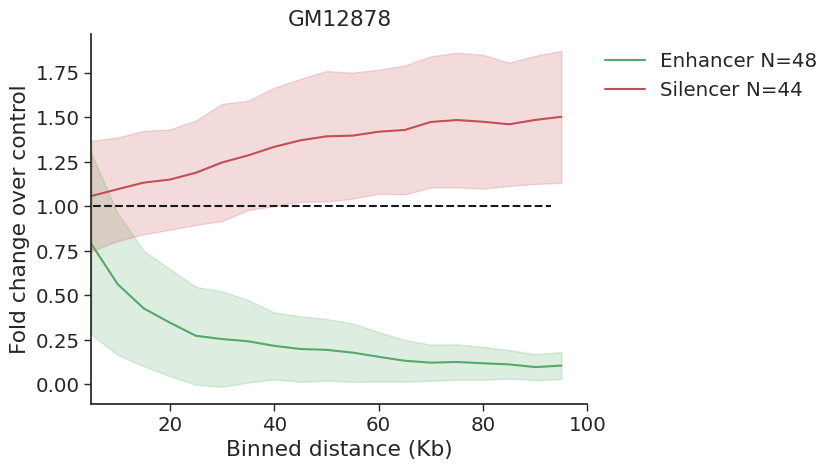

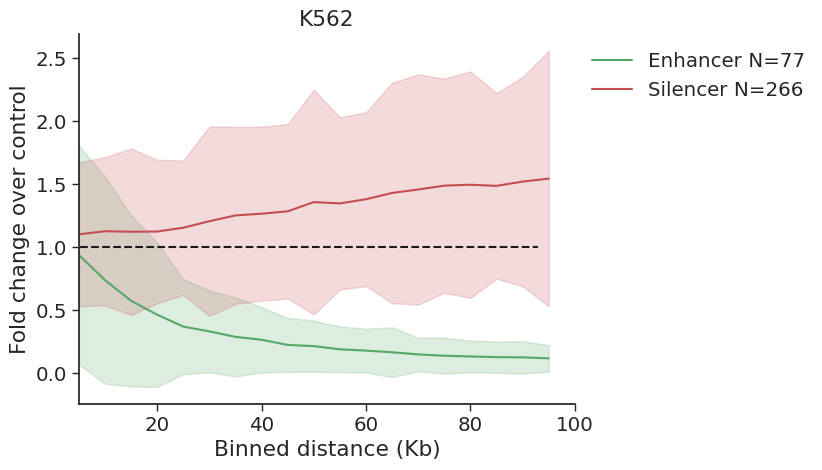

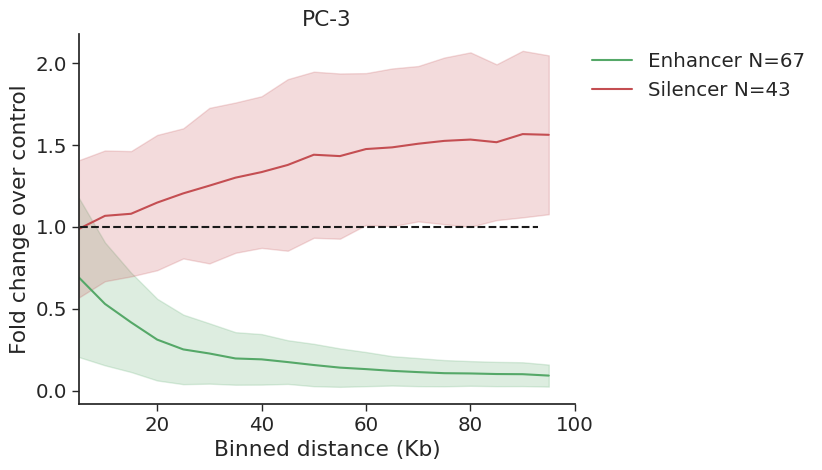

In [81]:
for cell_line, df in result_normalized_effects.groupby('cell line'):
    df = pd.concat([df[(df['context']=='enhancing') & (df['tile class']=='Enhancer')], df[(df['context']=='silencing') & (df['tile class']=='Silencer')]
])
    n_df = df.groupby(['tile class']).count()
    n_dict = dict(zip(list(n_df.index), n_df.iloc[:,-1]))
    my_palette = {}
    tile_labels = {}
    for i, row in n_df.iterrows():
        c = 'g' if i=='Enhancer' else 'r'
        my_palette[f'{i} N={row.iloc[0]//38}'] = c
        k = 'Enhancer' if 'Enh' in i else 'Silencer'
        tile_labels[k] = f'{i} N={row.iloc[0]//38}'
    df['tile class'] = [tile_labels[t] for t in df['tile class']]
    ax=sns.lineplot(data=df, x='Binned distance (Kb)', y='Fold change over control', hue='tile class', 
             errorbar='sd', palette=my_palette)
    ax.plot([1,93],[1,1], '--k')
    ax.set_xlim([5,100])
    # ax.set_ylim(0,1.75)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(cell_line)

    plt.legend(frameon=False, bbox_to_anchor=[1.5,1])
    plt.show()